In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from safetensors.torch import load_file

In [3]:
l = 15
lr = 8e-05
l1coef = 1.5
modelnames = ["base_llama", "Instruct_llama", "o_llama"]
cc_paths = [
    f"/inspire/hdd/ws-8207e9e2-e733-4eec-a475-cfa1c36480ba/embodied-multimodality/public/zfhe/zf_projects/Language-Model-SAEs/JR_CC_tests/{subject_model}_l{l}_32x_lr{lr}_jumprelu_l1coef{l1coef}/sae_weights.safetensors"
    for subject_model in modelnames
]

In [4]:
path = cc_paths[0]
ckpt = load_file(path)
path

'/inspire/hdd/ws-8207e9e2-e733-4eec-a475-cfa1c36480ba/embodied-multimodality/public/zfhe/zf_projects/Language-Model-SAEs/JR_CC_tests/base_llama_l15_32x_lr8e-05_jumprelu_l1coef1.5/sae_weights.safetensors'

In [5]:
ckpt

{'dataset_average_activation_norm.blocks.15.hook_resid_post': tensor(10.8326),
 'decoder.bias': tensor([ 0.0389,  0.0463, -0.0303,  ..., -0.0846, -0.2410,  0.1218]),
 'decoder.weight': tensor([[-0.0097, -0.0056, -0.0169,  ...,  0.0019,  0.0013,  0.0047],
         [ 0.0082, -0.0061, -0.0315,  ..., -0.0031, -0.0051, -0.0183],
         [ 0.0036,  0.0340,  0.0158,  ..., -0.0080,  0.0091, -0.0289],
         ...,
         [-0.0334, -0.0184, -0.0056,  ..., -0.0007, -0.0014, -0.0237],
         [ 0.0075, -0.0011,  0.0282,  ..., -0.0012, -0.0124,  0.0198],
         [-0.0054, -0.0003, -0.0174,  ..., -0.0063, -0.0021,  0.0434]]),
 'encoder.bias': tensor([-0.0216, -0.0104, -0.0106,  ..., -0.0160, -0.0142, -0.0137]),
 'encoder.weight': tensor([[-0.0261, -0.0016,  0.0188,  ..., -0.0244,  0.0139, -0.0167],
         [ 0.0069, -0.0008,  0.0142,  ..., -0.0102,  0.0026, -0.0035],
         [ 0.0020, -0.0103,  0.0191,  ...,  0.0097,  0.0093, -0.0143],
         ...,
         [ 0.0109,  0.0014, -0.0211,  ...,

In [6]:
decoders = []

for path in cc_paths:
    ckpt = load_file(path)

    # scaling_factor = (4096 ** .5) / ckpt[f'dataset_average_activation_norm.blocks.{layer}.hook_resid_post']
    decoders.append(ckpt["decoder.weight"].to("cuda"))

In [7]:
decoders[0]

tensor([[-0.0097, -0.0056, -0.0169,  ...,  0.0019,  0.0013,  0.0047],
        [ 0.0082, -0.0061, -0.0315,  ..., -0.0031, -0.0051, -0.0183],
        [ 0.0036,  0.0340,  0.0158,  ..., -0.0080,  0.0091, -0.0289],
        ...,
        [-0.0334, -0.0184, -0.0056,  ..., -0.0007, -0.0014, -0.0237],
        [ 0.0075, -0.0011,  0.0282,  ..., -0.0012, -0.0124,  0.0198],
        [-0.0054, -0.0003, -0.0174,  ..., -0.0063, -0.0021,  0.0434]],
       device='cuda:0')

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [9]:
tensor_a = decoders[0]  # B
tensor_b = decoders[2]  # O

In [10]:
cos_sim = F.cosine_similarity(tensor_a.T, tensor_b.T)  # 转置后计算每列之间的余弦相似度
cos_sim

tensor([0.8963, 0.9360, 0.9382,  ..., 0.1065, 0.9512, 0.7103], device='cuda:0')

In [73]:
dec_norms = []

with torch.no_grad():
    for dec in decoders:
        dec_norms.append(dec.norm(dim=0))

dec_norms = torch.stack(dec_norms)
dec_norms = dec_norms / dec_norms.sum(dim=0)
print(dec_norms)
dec_norms = dec_norms.T
print(dec_norms)
dec_norms = dec_norms[:, [0, 2]]
dec_norms.shape

tensor([[0.3312, 0.3456, 0.3289,  ..., 0.1393, 0.3360, 0.3968],
        [0.3440, 0.3370, 0.3348,  ..., 0.1557, 0.3291, 0.3378],
        [0.3248, 0.3174, 0.3364,  ..., 0.7049, 0.3348, 0.2654]],
       device='cuda:0')
tensor([[0.3312, 0.3440, 0.3248],
        [0.3456, 0.3370, 0.3174],
        [0.3289, 0.3348, 0.3364],
        ...,
        [0.1393, 0.1557, 0.7049],
        [0.3360, 0.3291, 0.3348],
        [0.3968, 0.3378, 0.2654]], device='cuda:0')


torch.Size([131072, 2])

In [12]:
diff = torch.abs(dec_norms[:, 0] - dec_norms[:, 1])
indices = torch.where(diff < 0.1)[0].tolist()
len(indices)

118264

In [13]:
filtered_b = decoders[0].T[indices]
filtered_o = decoders[1].T[indices]
print(filtered_b)
filtered_o

tensor([[-0.0097,  0.0082,  0.0036,  ..., -0.0334,  0.0075, -0.0054],
        [-0.0056, -0.0061,  0.0340,  ..., -0.0184, -0.0011, -0.0003],
        [-0.0169, -0.0315,  0.0158,  ..., -0.0056,  0.0282, -0.0174],
        ...,
        [ 0.0101,  0.0118,  0.0109,  ...,  0.0049,  0.0134, -0.0005],
        [ 0.0141,  0.0025,  0.0281,  ..., -0.0057,  0.0161, -0.0165],
        [ 0.0013, -0.0051,  0.0091,  ..., -0.0014, -0.0124, -0.0021]],
       device='cuda:0')


tensor([[-1.0158e-02,  5.9976e-03,  3.5641e-03,  ..., -3.6230e-02,
          7.0926e-03, -4.9541e-03],
        [-1.7913e-03, -7.9027e-03,  3.3743e-02,  ..., -1.7331e-02,
         -4.0826e-04,  6.4483e-04],
        [-1.8993e-02, -3.4891e-02,  1.1941e-02,  ..., -5.1350e-03,
          2.7872e-02, -2.0528e-02],
        ...,
        [ 1.0731e-02,  1.6392e-02,  4.1532e-03,  ...,  4.9065e-03,
          1.4126e-02,  7.1814e-04],
        [ 1.3526e-02,  9.8601e-03,  2.4040e-02,  ..., -1.2966e-02,
          1.4115e-02, -1.0489e-02],
        [ 9.0484e-04, -6.2776e-03,  1.1345e-02,  ...,  4.7754e-05,
         -1.8404e-02, -3.4315e-03]], device='cuda:0')

In [14]:
cos_sim = F.cosine_similarity(filtered_b, filtered_o)
# cos_sim.shape
torch.where(cos_sim < 0.99)[0].shape

torch.Size([103428])

In [15]:
log_counts = torch.log10(torch.histc(cos_sim, bins=100, min=-1, max=1))
log_counts = torch.where(torch.histc(cos_sim, bins=100, min=-1, max=1) == 0, torch.tensor(0), log_counts)
log_counts

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.3010, 0.0000, 0.3010, 0.6021, 0.6021, 0.6021,
        0.9031, 0.9031, 1.0414, 1.2304, 1.2553, 1.0414, 1.2788, 1.3617, 1.2553,
        1.0792, 1.2041, 1.0792, 1.3010, 1.2041, 1.0792, 1.0792, 1.1761, 1.3222,
        1.2041, 0.9031, 1.0792, 0.6021, 1.0792, 0.8451, 1.0000, 0.8451, 0.9542,
        0.7782, 0.9542, 1.1139, 0.6990, 0.6021, 0.7782, 0.9031, 0.9031, 0.6021,
        0.6021, 0.4771, 0.4771, 0.8451, 0.9031, 0.4771, 0.7782, 0.6990, 0.4771,
        0.6990, 0.3010, 0.6990, 0.0000, 0.6990, 0.6990, 0.6990, 0.8451, 0.9031,
        0.6990, 0.4771, 0.9542, 0.9542, 0.8451, 1.1761, 1.1139, 1.0000, 1.1139,
        1.3222, 1.1761, 1.3424, 1.4914, 1.5185, 1.7076, 1.8129, 1.7709, 2.0170,
        2.1931, 2.3522, 2.4969, 2.7340, 3.0095, 3.3872, 3.8532, 4.0900, 4.5576,
        4.7560], device='cuda:0')

In [16]:
bins = 100
bin_width = (1 - (-1)) / bins
bin_centers = torch.linspace(-1 + bin_width / 2, 1 - bin_width / 2, bins)

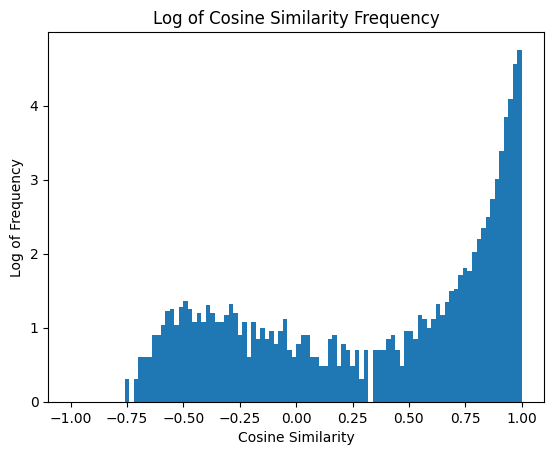

In [17]:
plt.bar(bin_centers.cpu().numpy(), log_counts.cpu().numpy(), width=bin_width)
plt.xlabel("Cosine Similarity")
plt.ylabel("Log of Frequency")
plt.title("Log of Cosine Similarity Frequency")
plt.show()

In [18]:
encoders = []

for path in cc_paths:
    ckpt = load_file(path)

    # scaling_factor = (4096 ** .5) / ckpt[f'dataset_average_activation_norm.blocks.{layer}.hook_resid_post']
    encoders.append(ckpt["encoder.weight"].to("cuda"))

In [31]:
encoders[0].shape

torch.Size([131072, 4096])

In [36]:
b_enc = encoders[0]
o_enc = encoders[2]
filtered_b_enc = b_enc[indices]
filtered_o_enc = o_enc[indices]
filtered_o_enc.shape

torch.Size([118264, 4096])

In [56]:
cos_sim_enc = F.cosine_similarity(filtered_b_enc, filtered_o_enc)
torch.where(cos_sim_enc < 0.1)[0].shape

torch.Size([1601])

In [53]:
hist_enc = torch.histc(cos_sim_enc, bins=100, min=-1, max=1)
log_counts_enc = torch.log10(hist_enc)
log_counts_enc = torch.where(hist_enc == 0, torch.tensor(0), log_counts_enc)
print(hist_enc)
log_counts_enc

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00,
        4.0000e+00, 4.0000e+00, 1.1000e+01, 1.1000e+01, 4.0000e+00, 5.0000e+00,
        1.1000e+01, 1.4000e+01, 1.1000e+01, 2.2000e+01, 2.0000e+01, 2.1000e+01,
        2.4000e+01, 2.0000e+01, 2.4000e+01, 4.1000e+01, 5.5000e+01, 7.2000e+01,
        7.2000e+01, 8.4000e+01, 1.1200e+02, 1.0800e+02, 1.0000e+02, 7.7000e+01,
        7.0000e+01, 6.2000e+01, 7.4000e+01, 8.4000e+01, 1.0700e+02, 1.1300e+02,
        1.5800e+02, 2.2000e+02, 2.5400e+02, 3.4500e+02, 4.7800e+02, 6.1300e+02,
        8.2700e+02, 1.2280e+03, 1.9310e+03, 2.9070e+03, 4.5760e+03, 6.6380e+03,
        8.7470e+03, 1.0541e+04, 1.1794e+04, 1.1485e+04, 1.0257e+04, 8.5950e+03,
        6.8620e+03, 5.7670e+03, 4.9720e+

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.4771, 0.4771, 0.6021, 0.6021, 1.0414,
        1.0414, 0.6021, 0.6990, 1.0414, 1.1461, 1.0414, 1.3424, 1.3010, 1.3222,
        1.3802, 1.3010, 1.3802, 1.6128, 1.7404, 1.8573, 1.8573, 1.9243, 2.0492,
        2.0334, 2.0000, 1.8865, 1.8451, 1.7924, 1.8692, 1.9243, 2.0294, 2.0531,
        2.1987, 2.3424, 2.4048, 2.5378, 2.6794, 2.7875, 2.9175, 3.0892, 3.2858,
        3.4634, 3.6605, 3.8220, 3.9419, 4.0229, 4.0717, 4.0601, 4.0110, 3.9342,
        3.8365, 3.7610, 3.6965, 3.6395, 3.5677, 3.5023, 3.3630, 3.2177, 3.0191,
        2.8182, 2.5694, 2.3054, 2.0043, 1.4314, 0.7782, 0.7782, 0.4771, 0.4771,
        0.6021, 0.4771, 0.3010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:0')

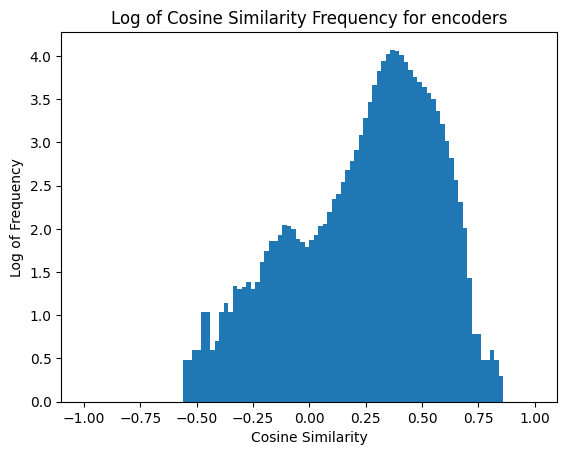

In [54]:
plt.bar(bin_centers.cpu().numpy(), log_counts_enc.cpu().numpy(), width=bin_width)
plt.xlabel("Cosine Similarity")
plt.ylabel("Log of Frequency")
plt.title("Log of Cosine Similarity Frequency for encoders")
plt.show()

In [65]:
cos_sim_dec_all = F.cosine_similarity(decoders[0].T, decoders[2].T)
negsimid = torch.where(cos_sim_dec_all < -0.7)[0].tolist()
interesting_id = list(set(negsimid) & set(indices))
interesting_id

[49760,
 91777,
 24353,
 117571,
 35789,
 89943,
 98640,
 65495,
 40051,
 39956,
 116244,
 98932,
 93302,
 89688,
 29881,
 69018,
 70459]

In [72]:
cos_sim_enc_all = F.cosine_similarity(encoders[0], encoders[2])
cos_sim_enc_all[interesting_id]

tensor([-0.3801, -0.2907, -0.3259, -0.1048, -0.3668, -0.0113, -0.5261, -0.3039,
        -0.3218, -0.0827, -0.3504, -0.4042, -0.4077, -0.1657, -0.5169, -0.4605,
        -0.3365], device='cuda:0')

In [70]:
cos_sim_dec_all[interesting_id]

tensor([-0.8593, -0.8101, -0.7474, -0.7252, -0.7676, -0.7274, -0.8766, -0.7104,
        -0.7374, -0.7791, -0.7041, -0.8593, -0.8209, -0.8519, -0.8222, -0.8124,
        -0.7253], device='cuda:0')